<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE (AutoEncoder)

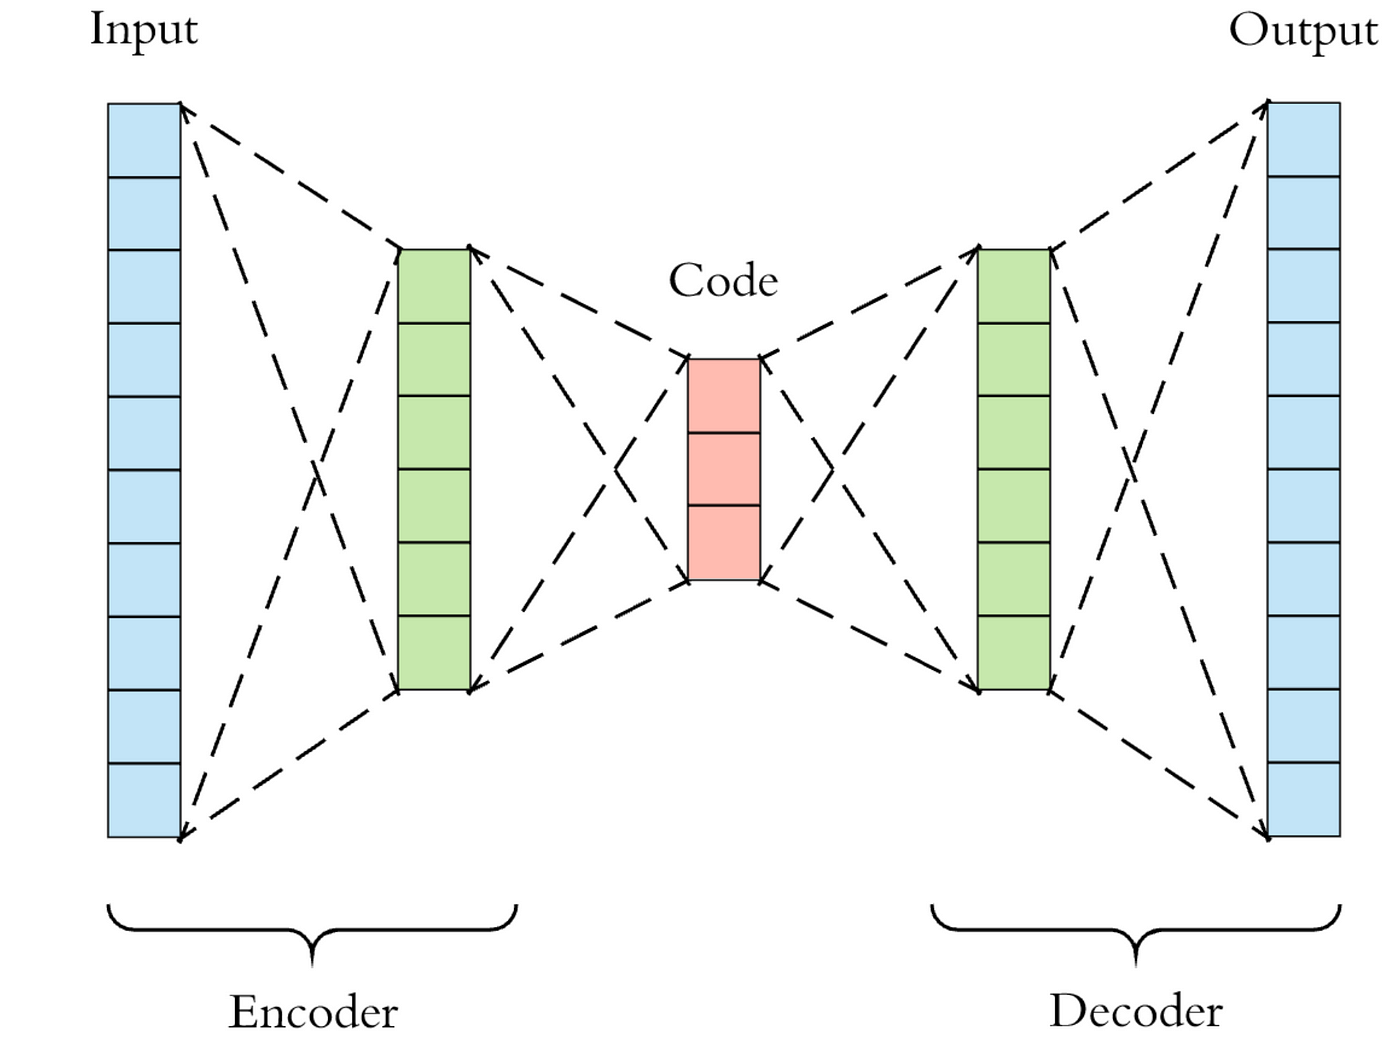

## 1. Load dataset

## 2. Import python libraries and define util functions

In [165]:
''' import '''
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from utils import get_device, get_data_model_path, set_seed, img_read, img_read_plot, plot_loss

In [166]:
''' set '''
device = get_device()
data_path, model_path = get_data_model_path(os.getcwd())
set_seed(0)

device, data_path, model_path

(device(type='cuda'),
 'd:\\workspace\\study\\DL2\\dataset',
 'd:\\workspace\\study\\DL2\\model')

## 3. Check dataset

## 4. Convert images into trainable data

In [167]:
''' load data '''
src = os.path.join(data_path, 'data_3000')
files = os.listdir(src)


X,Y = [],[]

for file in files:
    X.append(img_read(src, file) / 255.0)   # normalize
    Y.append(float(file[:-4]))              # label -> file name

X = np.array(X)
Y = np.array(Y)

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)

X.shape: (3000, 56, 56)
Y.shape: (3000,)


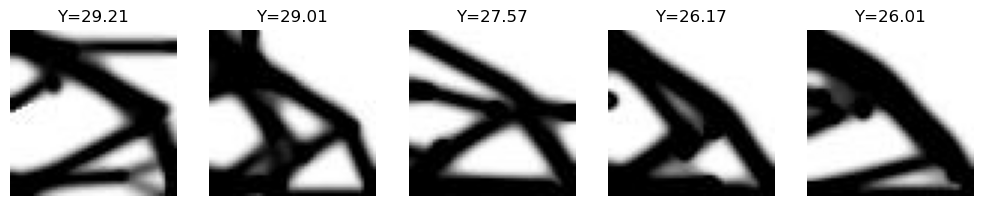

In [168]:
# check images
nplot = 5
idx = np.random.randint(1, 3000, nplot)

fig = plt.figure(figsize=(15,5))

for i in range(nplot):
    ax = fig.add_subplot(1, nplot+1, i+1)
    ax.imshow(X[idx[i],:,:], cmap='gray')
    ax.set_title(f"Y={Y[idx[i]]:.2f}")
    ax.axis('off')
plt.show()

## 5. Define dataloader

In [169]:
''' train test split '''
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X,Y, test_size=0.2, random_state=1, shuffle=True)

print(X_tr.shape, X_ts.shape, Y_tr.shape,Y_ts.shape)


# reshape (flatten)
X_tr = X_tr.reshape(-1, np.prod(X_tr.shape[1:])) # (2400, 56, 56) -> (2400, 56*56)
X_ts = X_ts.reshape(-1, np.prod(X_ts.shape[1:]))

print(X_tr.shape,X_ts.shape)


# convert to Tensor
X_tr = torch.tensor(X_tr, dtype=torch.float32).to(device)
Y_tr = torch.tensor(Y_tr, dtype=torch.float32)
X_ts = torch.tensor(X_ts, dtype=torch.float32).to(device)
Y_ts = torch.tensor(Y_ts, dtype=torch.float32)

(2400, 56, 56) (600, 56, 56) (2400,) (600,)
(2400, 3136) (600, 3136)


## 6. Set to model architecture

In [170]:
# input : 3136
# h1 : 512
# h2 : 20

''' model '''
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 20),
            nn.ReLU())

        self.decoder = nn. Sequential(
            nn.Linear(20, 512),
            nn.ReLU(),
            nn.Linear(512, 3136),
            nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [171]:
# plot model
ae = Autoencoder().to(device)

summary(ae, (3136,))  # input shape: (height*width, )
ae

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,606,144
              ReLU-2                  [-1, 512]               0
            Linear-3                   [-1, 20]          10,260
              ReLU-4                   [-1, 20]               0
            Linear-5                  [-1, 512]          10,752
              ReLU-6                  [-1, 512]               0
            Linear-7                 [-1, 3136]       1,608,768
              ReLU-8                 [-1, 3136]               0
Total params: 3,235,924
Trainable params: 3,235,924
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 12.34
Estimated Total Size (MB): 12.42
----------------------------------------------------------------


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=20, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3136, bias=True)
    (3): ReLU()
  )
)

## 7. Set model hyperparameters

In [172]:
''' hyper params '''
num_epochs = 200
batch_size = 40
learning_rate = 1e-3

''' loss, optim '''
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=ae.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.9)

In [173]:
''' dataloader '''
train_dataset = TensorDataset(X_tr, X_tr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)   # iter마다 batch 반환

## 8. Train model

Epoch [ 1/200], Train loss: 0.16784


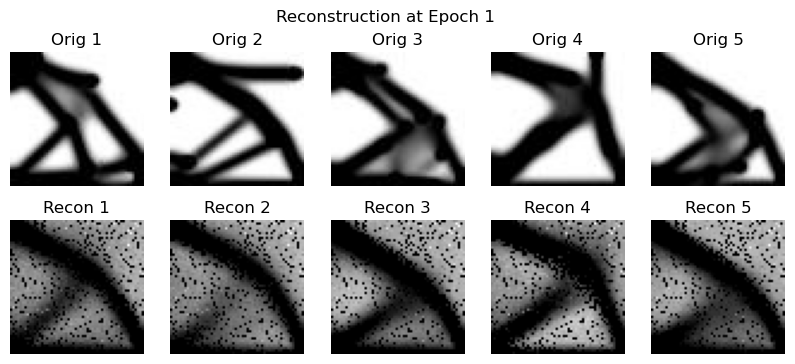

Epoch [ 2/200], Train loss: 0.09035
Epoch [ 3/200], Train loss: 0.07142
Epoch [ 4/200], Train loss: 0.06561
Epoch [ 5/200], Train loss: 0.06173
Epoch [ 6/200], Train loss: 0.05840
Epoch [ 7/200], Train loss: 0.05534
Epoch [ 8/200], Train loss: 0.05230
Epoch [ 9/200], Train loss: 0.05031
Epoch [10/200], Train loss: 0.04778
Epoch [11/200], Train loss: 0.04601
Epoch [12/200], Train loss: 0.04383
Epoch [13/200], Train loss: 0.04161
Epoch [14/200], Train loss: 0.04008
Epoch [15/200], Train loss: 0.03941
Epoch [16/200], Train loss: 0.03853
Epoch [17/200], Train loss: 0.03790
Epoch [18/200], Train loss: 0.03692
Epoch [19/200], Train loss: 0.03638
Epoch [20/200], Train loss: 0.03568
Epoch [21/200], Train loss: 0.03545
Epoch [22/200], Train loss: 0.03464
Epoch [23/200], Train loss: 0.03387
Epoch [24/200], Train loss: 0.03350
Epoch [25/200], Train loss: 0.03285
Epoch [26/200], Train loss: 0.03242
Epoch [27/200], Train loss: 0.03185
Epoch [28/200], Train loss: 0.03165
Epoch [29/200], Train loss: 

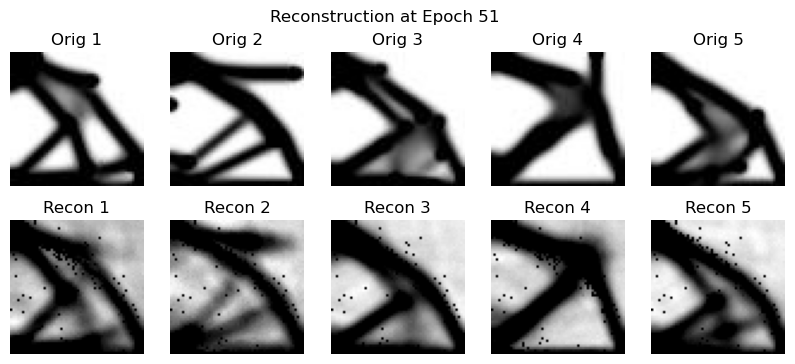

Epoch [52/200], Train loss: 0.02699
Epoch [53/200], Train loss: 0.02685
Epoch [54/200], Train loss: 0.02656
Epoch [55/200], Train loss: 0.02642
Epoch [56/200], Train loss: 0.02647
Epoch [57/200], Train loss: 0.02652
Epoch [58/200], Train loss: 0.02631
Epoch [59/200], Train loss: 0.02644
Epoch [60/200], Train loss: 0.02611
Epoch [61/200], Train loss: 0.02612
Epoch [62/200], Train loss: 0.02592
Epoch [63/200], Train loss: 0.02566
Epoch [64/200], Train loss: 0.02546
Epoch [65/200], Train loss: 0.02517
Epoch [66/200], Train loss: 0.02509
Epoch [67/200], Train loss: 0.02495
Epoch [68/200], Train loss: 0.02505
Epoch [69/200], Train loss: 0.02481
Epoch [70/200], Train loss: 0.02482
Epoch [71/200], Train loss: 0.02467
Epoch [72/200], Train loss: 0.02464
Epoch [73/200], Train loss: 0.02473
Epoch [74/200], Train loss: 0.02460
Epoch [75/200], Train loss: 0.02434
Epoch [76/200], Train loss: 0.02443
Epoch [77/200], Train loss: 0.02438
Epoch [78/200], Train loss: 0.02444
Epoch [79/200], Train loss: 

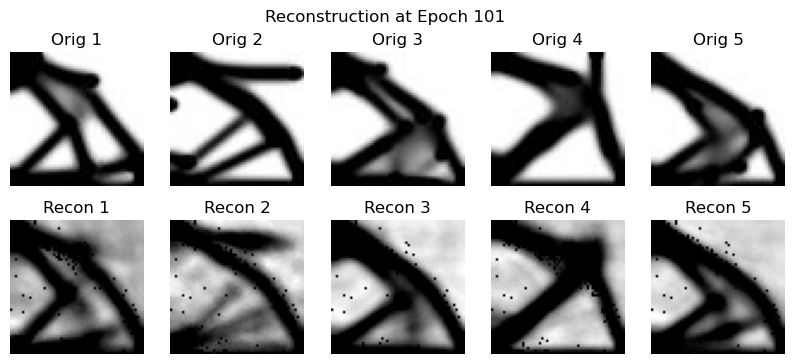

Epoch [102/200], Train loss: 0.02231
Epoch [103/200], Train loss: 0.02206
Epoch [104/200], Train loss: 0.02215
Epoch [105/200], Train loss: 0.02210
Epoch [106/200], Train loss: 0.02214
Epoch [107/200], Train loss: 0.02211
Epoch [108/200], Train loss: 0.02204
Epoch [109/200], Train loss: 0.02219
Epoch [110/200], Train loss: 0.02175
Epoch [111/200], Train loss: 0.02152
Epoch [112/200], Train loss: 0.02162
Epoch [113/200], Train loss: 0.02156
Epoch [114/200], Train loss: 0.02144
Epoch [115/200], Train loss: 0.02130
Epoch [116/200], Train loss: 0.02147
Epoch [117/200], Train loss: 0.02141
Epoch [118/200], Train loss: 0.02127
Epoch [119/200], Train loss: 0.02126
Epoch [120/200], Train loss: 0.02120
Epoch [121/200], Train loss: 0.02138
Epoch [122/200], Train loss: 0.02128
Epoch [123/200], Train loss: 0.02123
Epoch [124/200], Train loss: 0.02121
Epoch [125/200], Train loss: 0.02109
Epoch [126/200], Train loss: 0.02116
Epoch [127/200], Train loss: 0.02105
Epoch [128/200], Train loss: 0.02094
E

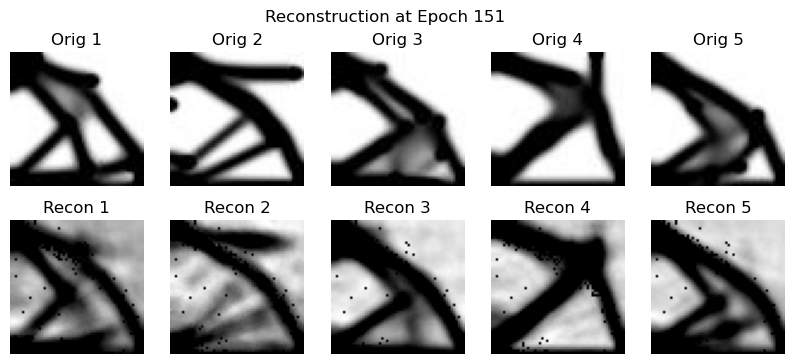

Epoch [152/200], Train loss: 0.02015
Epoch [153/200], Train loss: 0.02013
Epoch [154/200], Train loss: 0.02013
Epoch [155/200], Train loss: 0.02010
Epoch [156/200], Train loss: 0.02012
Epoch [157/200], Train loss: 0.02009
Epoch [158/200], Train loss: 0.01997
Epoch [159/200], Train loss: 0.01984
Epoch [160/200], Train loss: 0.02002
Epoch [161/200], Train loss: 0.01996
Epoch [162/200], Train loss: 0.01998
Epoch [163/200], Train loss: 0.02013
Epoch [164/200], Train loss: 0.01978
Epoch [165/200], Train loss: 0.01973
Epoch [166/200], Train loss: 0.01970
Epoch [167/200], Train loss: 0.01981
Epoch [168/200], Train loss: 0.01980
Epoch [169/200], Train loss: 0.01981
Epoch [170/200], Train loss: 0.01980
Epoch [171/200], Train loss: 0.01981
Epoch [172/200], Train loss: 0.01987
Epoch [173/200], Train loss: 0.01969
Epoch [174/200], Train loss: 0.01965
Epoch [175/200], Train loss: 0.01966
Epoch [176/200], Train loss: 0.01962
Epoch [177/200], Train loss: 0.01973
Epoch [178/200], Train loss: 0.01969
E

In [174]:
''' train '''
loss_tr_hist = []

for epoch in range(num_epochs):
    
    # training
    ae.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        output = ae(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)

    # history
    loss_tr_hist.append(avg_loss)
    print(f"Epoch [{epoch+1:2}/{num_epochs}], Train loss: {avg_loss:.5f}")

    scheduler.step()
    

    # validation
    if epoch % 50 == 0:
        ae.eval()
        with torch.no_grad():
            n = 5  # num of img

            plt.figure(figsize=(10, 4))
            
            for i in range(n):

                orig_img = X_ts.cpu()[i].reshape(56,56)
                recon_img = ae(X_ts[i]).detach().cpu().reshape(56,56)      # detach() : grad 연산 그래프에서 분리,     cpu() : gpu->cpu 복사

                # original
                ax = plt.subplot(2, n, i+1)
                plt.imshow(orig_img, cmap="gray")
                plt.title(f"Orig {i+1}")
                ax.axis('off')

                # recon
                ax = plt.subplot(2, n, i+1+n)
                plt.imshow(recon_img, cmap="gray")
                plt.title(f"Recon {i+1}")
                ax.axis('off')

            plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
            plt.show()
            ae.train()

# save model
torch.save(ae.state_dict(), os.path.join(model_path, 'AE_model.pth'))

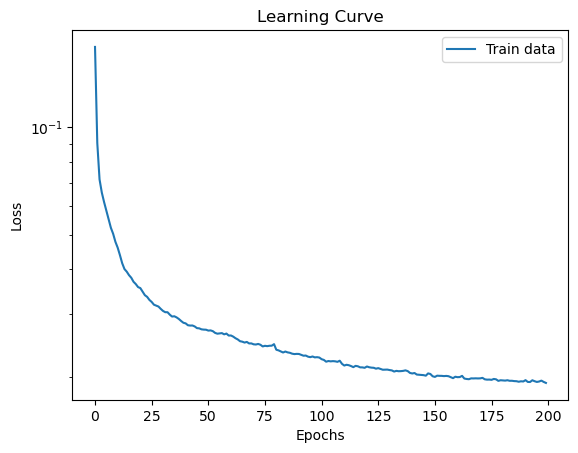

In [175]:
# graph visualization
plot_loss(loss_tr_hist, logy=True, title='Learning Curve')
plt.show()

## 9. Load & Evaluate model

- Compare the orginial image and the reconstructed image

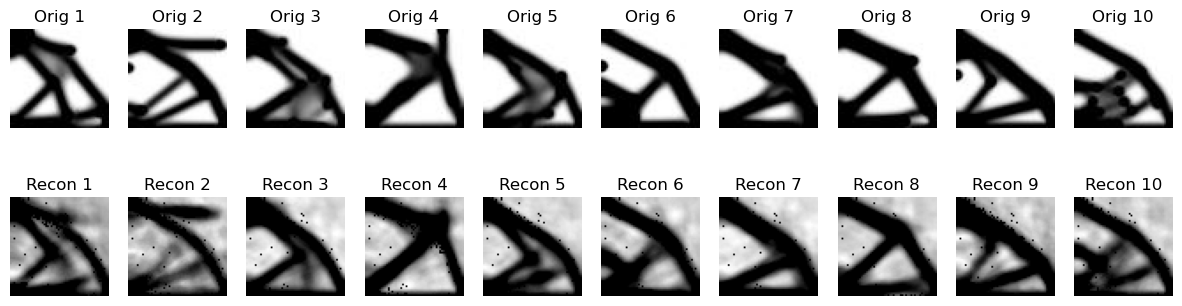

In [176]:
''' evaluation '''
ae.eval()
n = 10

plt.figure(figsize=(15, 4))

for i in range(n):
    
    orig_img = X_ts.cpu()[i].reshape(56,56)
    recon_img = ae(X_ts[i]).detach().cpu().reshape(56,56)

    # original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(orig_img, cmap="gray")
    plt.title(f"Orig {i+1}")
    ax.axis('off')

    # recon
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon_img, cmap="gray")
    plt.title(f"Recon {i+1}")
    ax.axis('off')

plt.show()

## 10. Visualize latent space using t-SNE (t-distributed Stochastic Neighbor Embedding)

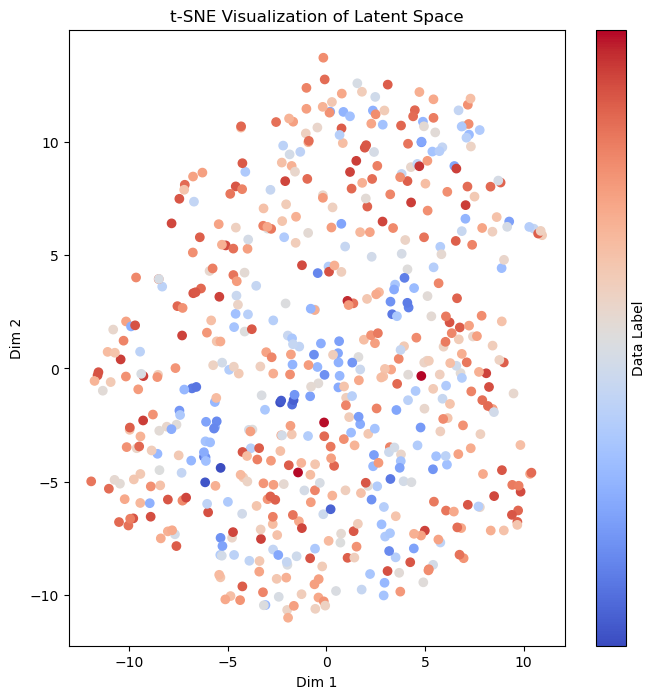

In [177]:
''' visulaize latent space '''
ae.eval()
with torch.no_grad():
    z = ae.encoder(X_ts).cpu().detach().numpy()   # latent space(z)

# dimension reduction (t-SNE)
tsne = TSNE(n_components=2, perplexity=70, random_state=0) # perplexity : num of neighbors
z_tsne = tsne.fit_transform(z)

# plot
plt.figure(figsize=(8, 8))
scatter = plt.scatter(z_tsne[:,0], z_tsne[:,1], c=Y_ts, cmap='coolwarm')

plt.colorbar(scatter, ticks=[0, 50], label='Data Label')
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.title("t-SNE Visualization of Latent Space")
plt.show()